In [1]:
!pip install pdfplumber
!pip install lightfm # 하이브리드 추천 시스템을 위한 대표 라이브러리
!pip install --upgrade gspread google-auth # 구글 시트-코랩 연동을 위한 라이브러리
!pip install --upgrade sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831164 sha256=d838427186a58a43574dbff16466a6e93cdfb052fc85cbd1725fb0c6963a02e3
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.38.0
    Uninstalling goo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.font_manager as fm
import warnings
from sentence_transformers import SentenceTransformer
from scipy.sparse import csr_matrix

from lightfm import LightFM
from lightfm.data import Dataset
from scipy.sparse import coo_matrix, csr_matrix

from bs4 import BeautifulSoup
import requests
import re
import io
import pdfplumber
from urllib.parse import urljoin

from google.colab import auth
auth.authenticate_user()

import google.auth
import gspread
from oauth2client.client import GoogleCredentials
from google.oauth2.service_account import Credentials

warnings.simplefilter("ignore")

import logging
logging.getLogger("pdfminer.pdfpage").setLevel(logging.ERROR)

import zipfile

In [19]:
recruit_df = pd.read_csv("/content/서울시 동대문구 채용 정보.csv", encoding='euc-kr', low_memory=False)

# '제목' 컬럼에 '합격', '면접', '결과' 단어가 들어간 행을 필터링하여 제거
recruit_df = recruit_df[~recruit_df['제목'].str.contains('합격|면접|결과', na=False)]
recruit_df = recruit_df.drop("일련번호", axis=1)
recruit_df = recruit_df.reset_index(drop=True)

recruit_df[:20]

,제목,링크,부서,등록일,내용
0,2025년 심뇌혈관질환 예방관리사업 기간제근로자(간호사) 채용 공고,https://www.ddm.go.kr/www/selectBbsNttView.do?...,보건행정과,2025-03-19,2025년 심뇌혈관질환 예방관리사업과 관련하여 기간제근로자(간호사)를 다음과 같이 ...
1,서울매력일자리(중증발달장애인 자립생활 역량강화를 위한 사회복지전문가 양성 과정) 사...,https://www.ddm.go.kr/www/selectBbsNttView.do?...,동행과,2025-03-17,◎ 추가모집 개요 1. 접수기간 : 2025. 3. 17. ? 3. 24. 1...
2,「2025년 어린이 교통안전지도사업」참여자 추가모집 공고(휘봉초),https://www.ddm.go.kr/www/selectBbsNttView.do?...,교통행정과,2025-03-17,「2025년 어린이 교통안전지도사업」참여자 추가모집 공고(휘봉초) 동대문구에서는 ...
3,임기제공무원 채용 재공고(주차단속),https://www.ddm.go.kr/www/selectBbsNttView.do?...,행정지원과,2025-03-14,서울특별시 동대문구인사위원회 공고 제2025?13호 ...
4,동대문구청 후생시설(구내식당) 기간제근로자 신규 채용 공고,https://www.ddm.go.kr/www/selectBbsNttView.do?...,행정지원과,2025-03-14,[동대문구청 후생시설(구내식당) 기간제근로자 신규 채용 공고] 1. 채용인원 : ...
5,동대문구육아종합지원센터 서울형 키즈카페 직원 채용공고,https://www.ddm.go.kr/www/selectBbsNttView.do?...,가족정책과,2025-03-13,동대문구육아종합지원센터 서울형 키즈카페 직원을 아래와 같이 모집하오니 많은 관심 부...
6,(사)대한노인회 동대문구지회 경로당 운영관리자(경로과장) 채용 모집 공고,https://www.ddm.go.kr/www/selectBbsNttView.do?...,동행과,2025-03-12,(사)대한노인회 동대문구지회에서는 경로당 운영관리 담당자(경로과장) 모집을 다음과 ...
7,「2025년 어린이 교통안전지도사업」참여자 3차 재모집 공고,https://www.ddm.go.kr/www/selectBbsNttView.do?...,교통행정과,2025-03-11,「2025년 어린이 교통안전지도사업」참여자 3차 재모집 공고 동대문구에서는 202...
8,2025년 육군 학사장교 모집,https://www.ddm.go.kr/www/selectBbsNttView.do?...,NaN,2025-03-11,2025년 육군 학사장교 모집
9,민간 부사관 2기 모집,https://www.ddm.go.kr/www/selectBbsNttView.do?...,NaN,2025-03-11,민간 부사관 2기 모집


In [20]:
recruit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      348 non-null    object
 1   링크      348 non-null    object
 2   부서      306 non-null    object
 3   등록일     348 non-null    object
 4   내용      348 non-null    object
dtypes: object(5)
memory usage: 13.7+ KB


In [21]:
link_list = recruit_df['링크'].tolist()
link_list

['https://www.ddm.go.kr/www/selectBbsNttView.do?key=208&bbsNo=42&nttNo=165367',
 'https://www.ddm.go.kr/www/selectBbsNttView.do?key=208&bbsNo=42&nttNo=165310',
 'https://www.ddm.go.kr/www/selectBbsNttView.do?key=208&bbsNo=42&nttNo=165309',
 'https://www.ddm.go.kr/www/selectBbsNttView.do?key=208&bbsNo=42&nttNo=165298',
 'https://www.ddm.go.kr/www/selectBbsNttView.do?key=208&bbsNo=42&nttNo=165281',
 'https://www.ddm.go.kr/www/selectBbsNttView.do?key=208&bbsNo=42&nttNo=165276',
 'https://www.ddm.go.kr/www/selectBbsNttView.do?key=208&bbsNo=42&nttNo=165218',
 'https://www.ddm.go.kr/www/selectBbsNttView.do?key=208&bbsNo=42&nttNo=165205',
 'https://www.ddm.go.kr/www/selectBbsNttView.do?key=208&bbsNo=42&nttNo=165189',
 'https://www.ddm.go.kr/www/selectBbsNttView.do?key=208&bbsNo=42&nttNo=165188',
 'https://www.ddm.go.kr/www/selectBbsNttView.do?key=208&bbsNo=42&nttNo=165134',
 'https://www.ddm.go.kr/www/selectBbsNttView.do?key=208&bbsNo=42&nttNo=162523',
 'https://www.ddm.go.kr/www/selectBbsNtt

# 필요한 정보
# 1. user_text: 유저 자신의 취업 정보와 관련된 문장
# 2. item_text: 채용 공고 문장
# 3. interaction_data: 유저가 관심있는 채용 공고 인덱스


In [ ]:
def extract_hwpx_text_from_url(url):
    # HTTP GET
    headers = {"User-Agent": "Mozilla/5.0"}
    resp = requests.get(url, headers=headers)
    resp.raise_for_status()

    # 메모리 ZIP 열기
    hwpx_bytes = io.BytesIO(resp.content)
    with zipfile.ZipFile(hwpx_bytes) as z:
        # Preview 텍스트 파일 경로
        preview_path = "Preview/PrvText.txt"
        if preview_path not in z.namelist():
            raise FileNotFoundError(f"{preview_path} 미존재: 내부파일목록={z.namelist()}")
        raw = z.read(preview_path)
        return raw.decode('utf-8')

def extract_pdf_text_from_url(url):
  headers = {"User-Agent": "Mozilla/5.0"}
  response = requests.get(full_url, headers=headers)

  # PDF 파일 다운로드 (메모리 상에서 처리)
  pdf_bytes = io.BytesIO(response.content)

  # pdfplumber로 텍스트 추출
  text = ""
  with pdfplumber.open(pdf_bytes) as pdf:
      for page in pdf.pages:
          page_text = page.extract_text()
          if page_text:
              text += page_text + "\n"
  return text

def detect_type(url):
    resp = requests.get(url, headers={"User-Agent":"Mozilla/5.0"}, stream=True)
    resp.raise_for_status()
    magic = resp.raw.read(4)


    if magic.startswith(b"%PDF"):
        return "pdf"
    if magic.startswith(b"PK\x03\x04"):
        return "hwpx"
    return "unknown"

In [ ]:
# 2. item_text : '링크' 열의 채용 공고 pdf 파일의 텍스트 추출
item_texts = []
total_links = len(link_list)

for idx, i in enumerate(link_list, start=1):
    try:
        base_url = i  # 절대 url

        # headers 추가해서 html 가져오기
        headers = {"User-Agent": "Mozilla/5.0"}
        r = requests.get(base_url, headers=headers)

        # HTML 파싱
        soup = BeautifulSoup(r.text, 'html.parser')

        # downloadBbsFile.do 가 포함된 모든 <a> 태그 중, 내부 텍스트에 "공고"가 포함된 태그 찾기
        link_tag = None
        for tag in soup.find_all('a', href=lambda x: x and 'downloadBbsFile.do' in x):
            if '공고' in tag.get_text():
                link_tag = tag
                break

        # 상대 주소 및 절대 URL 구성
        relative_url = link_tag['href']
        full_url = urljoin(base_url, relative_url)
        file_ext = detect_type(full_url)
        if (file_ext == "hwpx"):
            text = extract_hwpx_text_from_url(full_url)
            item_texts.append(text)
        elif (file_ext == "pdf"):
            text = extract_pdf_text_from_url(full_url)
            item_texts.append(text)
        else:
            raise ValueError()

    except Exception as e:
        # 예외 발생 시, recruit_df에서 제목, 내용, 본문 텍스트 추출
        base_url = i  # 절대 url
        headers = {"User-Agent": "Mozilla/5.0"}
        r = requests.get(base_url, headers=headers)
        soup = BeautifulSoup(r.text, 'html.parser')
        content_element = soup.find("td", class_="p-table__content", title="내용")
        main_text = content_element.get_text(separator="\n", strip=True) if content_element else ""
        row = recruit_df[recruit_df['링크'] == i]
        text = str(row['제목'].iloc[0]) + " " + str(row['내용'].iloc[0]) + " " + main_text
        item_texts.append(text)

    # 10개마다 진행 상황 출력
    if idx % 10 == 0:
        print(f"진행 상황: {total_links}개 중 {idx}개 처리됨.")


진행 상황: 348개 중 10개 처리됨.
진행 상황: 348개 중 20개 처리됨.
진행 상황: 348개 중 30개 처리됨.
진행 상황: 348개 중 40개 처리됨.
진행 상황: 348개 중 50개 처리됨.
진행 상황: 348개 중 60개 처리됨.
진행 상황: 348개 중 70개 처리됨.
진행 상황: 348개 중 80개 처리됨.
진행 상황: 348개 중 90개 처리됨.
진행 상황: 348개 중 100개 처리됨.
진행 상황: 348개 중 110개 처리됨.
진행 상황: 348개 중 120개 처리됨.
진행 상황: 348개 중 130개 처리됨.
진행 상황: 348개 중 140개 처리됨.
진행 상황: 348개 중 150개 처리됨.
진행 상황: 348개 중 160개 처리됨.
진행 상황: 348개 중 170개 처리됨.
진행 상황: 348개 중 180개 처리됨.
진행 상황: 348개 중 190개 처리됨.
진행 상황: 348개 중 200개 처리됨.
진행 상황: 348개 중 210개 처리됨.
진행 상황: 348개 중 220개 처리됨.
진행 상황: 348개 중 230개 처리됨.
진행 상황: 348개 중 240개 처리됨.
진행 상황: 348개 중 250개 처리됨.
진행 상황: 348개 중 260개 처리됨.
진행 상황: 348개 중 270개 처리됨.
진행 상황: 348개 중 280개 처리됨.
진행 상황: 348개 중 290개 처리됨.
진행 상황: 348개 중 300개 처리됨.
진행 상황: 348개 중 310개 처리됨.
진행 상황: 348개 중 320개 처리됨.
진행 상황: 348개 중 330개 처리됨.
진행 상황: 348개 중 340개 처리됨.


In [3]:
# item_texts를 pickle 객체로 저장

import pickle

with open("item_texts.ver2.pkl", "wb") as f:
    pickle.dump(item_texts, f)

NameError: name 'item_texts' is not defined

In [8]:
# pickle 객체를 다시 item_texts로 복구

import pickle

# 파일을 읽기 모드로 열어서 pickle 객체를 로드합니다.
with open('/content/item_texts.ver2.pkl', 'rb') as file:
    item_texts = pickle.load(file)

In [9]:
item_texts

['서울특별시 동대문구보건소 공고 제2025- 호\n2025년 심뇌혈관질환 예방관리사업 기간제근로자(간호사) 채용 공고\n\x00\x00서울특별시 동대문구보건소에서 근무할 심뇌혈관질환 예방관리사업 기간제 근로자를 아래와\n같이 공개 모집하오니 유능한 인재의 많은 응모 바랍니다.\n2025. 3.\n서울특별시 동대문구청장\n1. 채용분야 및 선발 예정인원\n채용분야 채용인원 근무기간 및 시간 담당 직무내용\n· 심뇌혈관질환 예방관리 업무 또는 내과 진료실 접수\n- 심뇌혈관질환 고위험군 및 환자 건강상담 관리\n2025. 4. 9. ~ 2026. 2. 28.\n간호사 1명 - 고혈압·당뇨병 교육, 프로그램 운영, 캠페인\n09:00~18:00(1일 8시간)\n진행 및 홍보 등\n· 기타 필요시 모바일헬스케어 사업 등 업무 지원\n2. 응시 자격요건\n※ 채용 공고일 기준\n가. 대학(원)에서 간호학과를 졸업하고 간호사 면허증을 취득한 자\n나. 아동‧청소년 성범죄 및 장애인‧노인학대 범죄 전력이 없는 자\n대상 관련 근거\n· 아동·청소년의 성보호에 관한 법률 제56조\n(아동·청소년관련기관등에의 취업 제한 등)\n의료인\n· 아동복지법 제29조의 3(아동관련기관의 취업제한 등)\n(간호사)\n· 장애인복지법 제59조의 3(장애인관련기관에의 취업제한 등)\n· 노인복지법 제39조의 17(노인관련기관의 취업제한 등)\n※ 위 범죄 전력이 확인된 경우 합격을 취소함\n다. 우대조건(응시원서에 반드시 기재)\n- 6개월 이상 채용 예정 직무 분야의 실무경력이 있는 자\n※ 관련 분야 경력 인정범위: 국가, 지방자치단체, 공공·민간기관 등에서의 실무경력\n- PC 활용 가능자(워드프로세서, MS office 등 PC 관련 자격증 소지자)\n3. 근무조건 및 보수 수준\n가. 근무기간: 2025. 4. 9.~2026. 2. 28.(11개월)\n※ 단, 채용절차 및 예산범위 등에 따라 기간 변경 가능\n나. 근무장소: 동대문구보건소\n다. 근무시간 및 보수 수준\n구분 지

In [10]:
## 전처리에 필요한 라이브러리 설치

!apt-get update
!apt-get install -y openjdk-8-jdk-headless
!pip install konlpy jpype1

import re
import pickle
from konlpy.tag import Okt
from tqdm import tqdm

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,665 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,926 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,901 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadco

In [11]:
## 전처리 적용

okt = Okt()

# 도메인 불용어 집합
domain_stopwords = {
    # 문서 메타·제목 관련
    '서울특별시', '동대문구', '동대문구청', '동대문구청장', '동대문구인사위원회',
    '제', '호', '공고', '재공고', '추가모집', '모집공고',
    # 채용·근무 포맷
    '채용', '근로자', '기간제', '기간제근로자', '사업', '참여자', '인원', '직무내용',
    '근무기간', '근무시간', '임용', '임용분야', '담당직무', '제출서류',
    # 일반 안내 문구
    '붙임', '첨부', '내용', '제출', '방법', '기타', '관련', '안내', '확인', '문의',
    # 웹·링크
    'http', 'https', 'www', '링크'
 }

def preprocess(text):
    # 줄바꿈, nbsp 정리
    text = text.replace('\xa0', ' ')
    text = re.sub(r'\s+', ' ', text).strip()

    # 토큰 필터링 적용
    tokens = okt.morphs(text)
    filtered = []
    for t in tokens:
        # 숫자, 짧은 거, 도메인 불용어 걸러내기
        if t.isdigit():
            continue
        if len(t) <= 1:
            continue
        if t in domain_stopwords:
            continue
        filtered.append(t)


    return " ".join(filtered)  # 다시 문장으로 합쳐서 반환

processed_texts = [preprocess(t) for t in tqdm(item_texts)]

100%|██████████| 348/348 [01:41<00:00,  3.42it/s]


In [12]:
item_texts = processed_texts

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sentence_transformers import models

# 임베딩 입력 -> 실루엣 스코어를 반환
# 응집도(cohesion)와 분리도(separation)를 종합해 −1에서 1 사이 점수로 반환(1에 가까울수록 좋음)
def eval_emb(embs):
    km = KMeans(n_clusters=5, random_state=42, n_init=10)
    labels = km.fit_predict(embs)
    return silhouette_score(embs, labels)

configs = ['sentence-transformers/all-MiniLM-L6-v2',
           'jhgan/ko-sroberta-multitask',
           'snunlp/KR-SBERT-V40K-klueNLI-augSTS',
           'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
           'sentence-transformers/LaBSE'
]

results = []
for c in configs:
    print(f"{c} 평가 시작…")
    tm = models.Transformer(c, max_seq_length=128)
    pm = models.Pooling(tm.get_word_embedding_dimension(), pooling_mode='mean')
    m  = SentenceTransformer(modules=[tm, pm])
    embs = m.encode(item_texts, show_progress_bar=False, convert_to_numpy=True)
    score = eval_emb(embs)
    results.append((c, score))


sentence-transformers/all-MiniLM-L6-v2 평가 시작…


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

jhgan/ko-sroberta-multitask 평가 시작…


config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

snunlp/KR-SBERT-V40K-klueNLI-augSTS 평가 시작…


config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 평가 시작…


config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

sentence-transformers/LaBSE 평가 시작…


config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
df = pd.DataFrame(results, columns=['model', 'silhouette'])
print("최종 실험 결과 (실루엣 스코어 기준 내림차순):")
print(df.reset_index(drop=True))

최종 실험 결과 (실루엣 스코어 기준 내림차순):
                                               model  silhouette
0             sentence-transformers/all-MiniLM-L6-v2    0.147778
1                        jhgan/ko-sroberta-multitask    0.100567
2                snunlp/KR-SBERT-V40K-klueNLI-augSTS    0.077399
3  sentence-transformers/paraphrase-multilingual-...    0.076093
4                        sentence-transformers/LaBSE    0.066122


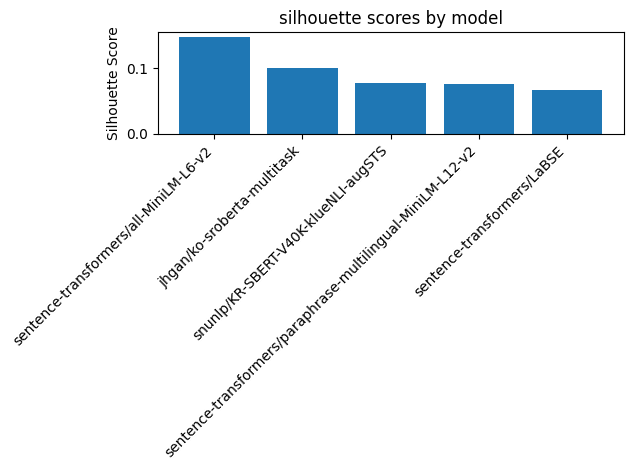

In [ ]:
plt.figure()
plt.bar(df['model'], df['silhouette'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Silhouette Score')
plt.title('silhouette scores by model')
plt.tight_layout()
plt.show()

In [13]:
# 2. SBERT로 임베딩 (두 텍스트 모두 동일 모델 사용)
sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# 채용 공고 텍스트 임베딩 (결과 shape: (n_items, embedding_dim))
item_embeddings = sbert_model.encode(item_texts, normalize_embeddings=True)

# 3. LightFM이 요구하는 sparse matrix 형태로 변환
item_features = csr_matrix(item_embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
item_embeddings

array([[ 0.0203454 ,  0.02611826,  0.07653883, ..., -0.00202158,
        -0.05134797,  0.01425892],
       [ 0.03214526,  0.01739237,  0.06586852, ..., -0.04176602,
        -0.06709444, -0.01585496],
       [ 0.01358507,  0.0226193 ,  0.09187212, ..., -0.00469059,
        -0.09968899, -0.00429125],
       ...,
       [ 0.01445561, -0.00308064,  0.00762281, ..., -0.03589502,
        -0.0879923 ,  0.00611647],
       [ 0.02756533,  0.01307679, -0.00523585, ..., -0.03042134,
        -0.04831271,  0.00134135],
       [-0.01086421,  0.07121235,  0.1222783 , ...,  0.01624369,
        -0.10562382, -0.00409729]], dtype=float32)

In [15]:
item_features

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 133632 stored elements and shape (348, 384)>

In [23]:
# 1. user_text, 3. interaction_data : 구글폼에서 입력받아서 구글 스프레드시트 가져오기

# Google Sheets API를 사용할 범위 지정
scopes = ['https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive']

# 기본 인증을 사용하는 경우
gc = gspread.authorize(google.auth.default(scopes=scopes)[0])

# 스프레드시트 열기 (문서 URL이나 제목을 사용)
spreadsheet = gc.open("구직자 응답")  # 스프레드시트 제목 사용
worksheet = spreadsheet.sheet1  # 첫 번째 시트 선택

# 데이터 가져오기
data = worksheet.get_all_records()
job_seekers = pd.DataFrame(data)

# 구직자 프로필 텍스트 생성
def create_profile_text(row):
    profile = f"직무: {job_seekers.loc[row, '직무']} 경력: {job_seekers.loc[row, '경력']} 자격증: {job_seekers.loc[row, '자격증']} 전공: {job_seekers.loc[row, '전공']} 기술: {job_seekers.loc[row, '기술']}"
    return profile

n = 3 # 구글 시트에서 몇번째 사람 데이터인지
user_text = create_profile_text(n)

input_str = job_seekers.loc[n, '관심 있는 공고 인덱스']

# 정규표현식을 사용하여 문자열에서 숫자(연속된 숫자들)를 추출합니다.
numbers = re.findall(r'\d+', input_str)

# 추출된 문자열 숫자들을 정수로 변환하고, ('user_1', 숫자) 형태의 튜플로 리스트를 생성합니다.
interaction_data = [('user_1', int(num)) for num in numbers]

user_text

'직무: 공공기관 행정지원 및 사무 보조 경력: 지방자치단체 행정팀 인턴 경험, 문서 정리 및 공문 작성 업무 수행 자격증: 컴퓨터활용능력 2급, 워드프로세서 1급 전공: 행정학과 기술: 문서 작성(한글, MS Office), 데이터 정리 및 보고서 작성, 전자결재 시스템 사용 가능'

In [24]:
# 2. SBERT로 임베딩 (두 텍스트 모두 동일 모델 사용)
sbert_model = SentenceTransformer("jhgan/ko-sroberta-multitask")

# 유저 텍스트 임베딩 (결과 shape: (1, embedding_dim))
user_embedding = sbert_model.encode([user_text], normalize_embeddings=True)

# 3. LightFM이 요구하는 sparse matrix 형태로 변환
user_features = csr_matrix(user_embedding)
item_features = csr_matrix(item_embeddings)

# 4. Dataset 생성
# 유저는 한 명, 아이템은 채용 공고 리스트의 인덱스로 사용
dataset = Dataset()
dataset.fit(users=['user_1'], items=list(range(len(item_texts))))

# 5. interaction 생성
(interactions, _) = dataset.build_interactions(interaction_data)

# 6. LightFM 모델 학습 (user_features와 item_features 모두 사용)
model = LightFM(loss='warp')
model.fit(interactions, user_features=user_features, item_features=item_features,
          epochs=30, num_threads=2)

# 7. 유저에 대해 모든 공고 점수 예측 후 추천 순위 도출
scores = model.predict(0, np.arange(len(item_texts)), user_features=user_features, item_features=item_features)
recommended_order = np.argsort(-scores)

print("<추천 결과>")
for idx in recommended_order[:5]:
    print(f"{idx}: {recruit_df.loc[idx, '제목']} (score: {scores[idx]:.4f})")

<추천 결과>
85: (사)대한노인회 동대문구지회 2025년 노인사회활동지원사업 담당자 모집(전담인력) 공고 (score: -4.8766)
82: 2025년 소나무센터(위기가정통합지원센터) 기간제근로자(상담원) 채용 공고 (score: -5.2035)
307: (사) 대한노인회 동대문구지회 2024년 노인일자리 및 사회활동 지원사업 담당자(구 전담인력) 모집 공고 (score: -5.5241)
122: 서울 365 청결기동대 기간제근로자 추가 채용공고(2차) (score: -5.6225)
132: 2024년도 서울365청결기동대 추가채용 공고 (score: -5.6225)
